In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# DATA_DIR = '../../../In-situ Meas Data/Build Command Data/XYPT Commands/' # Directory of XYPT files
DATA_DIR = '../../../RTC_Images/'

dt = 1E-5 # 10 microseconds

In [3]:
# data = pd.read_csv(DATA_DIR + 'T500_3D_Scan_Strategies_fused_layer0002.csv', header=None, names=['X', 'Y', 'P', 'T', 'deprecated'])
data = pd.read_csv(DATA_DIR + 'RTC_XYL_DAQ_IN625_Ar_P01I2000D10_RefA400_Base.csv', header=None, names=['X', 'Y', 'P', 'T'])

In [6]:
trigger_indx = np.where(np.array(data['T']))[0]
X = np.array(data['X'])
Y = np.array(data['Y'])
P = np.array(data['P'])

In [7]:
# Speed
x_vel = np.zeros(X.shape)
x_vel[1:-1] = (X[2:]-X[:-2]) / 2 / dt

y_vel = np.zeros(X.shape)
y_vel[1:-1] = (Y[2:]-Y[:-2]) / 2 / dt

speed = np.sqrt(np.square(x_vel) + np.square(y_vel))

In [8]:
# Direction
vel_dir_x = x_vel / (speed + 1e-8)
vel_dir_y = y_vel / (speed + 1e-8)

In [9]:
# Acceleration
x_accel = np.zeros(X.shape)
x_accel[1:-1] = (x_vel[2:]-x_vel[:-2]) / 2 / dt

y_accel = np.zeros(Y.shape)
y_accel[1:-1] = (y_vel[2:]-y_vel[:-2]) / 2 / dt

accel = np.sqrt(np.square(x_accel) + np.square(y_accel))
accel[np.where(speed[1:] < speed[:-1])[0]+1] = accel[np.where(speed[1:] < speed[:-1])[0]+1]*-1

In [10]:
# Energy Density
en_den = P / (speed + 1e-8)

In [11]:
# Heating/Cooling
heating = np.zeros(X.shape)
heating[np.where(P[1:]>P[:-1])[0]+1] = 1
heating[np.where(P[1:]<P[:-1])[0]+1] = -1

In [12]:
# Turning
turn_threshold = 0.01 # Tune me

turning = np.zeros(X.shape)
turn1 = np.zeros(X.shape)
turn2 = np.zeros(X.shape)

turn1[1:] = np.abs(vel_dir_x[1:]-vel_dir_x[:-1])
turn2[1:] = np.abs(vel_dir_y[1:]-vel_dir_y[:-1])
turning = np.any([(turn1 > turn_threshold), (turn2 > turn_threshold)], axis=0)
turning = turning.astype('int')

In [13]:
# Residual Heat
R = 10 # parts are 10 mm x 10 mm
T = 5
max_iters = round(T/dt)

residual_heat = np.zeros(X.shape[0])
for i in tqdm(trigger_indx):
    d_ij = np.sqrt(np.square(X[i]-X[max(0, i-max_iters):i]) + np.square(Y[i]-Y[max(0, i-max_iters):i]))
    t_ij = np.linspace((min(max_iters, i))*dt, dt, min(max_iters, i))
    p_j = P[max(0, i-max_iters):i]
    residual_heat[i] += np.sum(np.square((R-d_ij)/R) * ((T-t_ij)/T) * p_j)

100%|███████████████████████████████████████████████████████████████████████████| 20903/20903 [01:15<00:00, 278.34it/s]


In [128]:
# Merge together, normalize, and save to an excel file
P_trig = P[trigger_indx]
speed_trig = speed[trigger_indx]
x_dir_trig = vel_dir_x[trigger_indx]
y_dir_trig = vel_dir_y[trigger_indx]
accel_trig = accel[trigger_indx]
en_den_trig = en_den[trigger_indx]
heating_trig = heating[trigger_indx]
turning_trig = turning[trigger_indx]
residual_heat_trig = residual_heat[trigger_indx]

pp = pd.DataFrame({'P': P_trig, 'speed': speed_trig, 'x_dir': x_dir_trig, 'y_dir': y_dir_trig, 'accel': accel_trig,
                  'ed': en_den_trig, 'heating': heating_trig, 'turning': turning_trig, 'res_heat': residual_heat_trig})



# pp_normalized = pd.DataFrame()


In [ ]:
# Merge with the labels excel files
label = pd.read_excel()


### Now cycle through each layer 

In [4]:
for ii in tqdm(range(2,251)):
    if ii < 10:
        layer_text = 'layer000' + str(ii)
    elif ii < 100:
        layer_text = 'layer00' + str(ii)
    else:
        layer_text = 'layer0' + str(ii)
        
    data = pd.read_csv(DATA_DIR + 'T500_3D_Scan_Strategies_fused_' + layer_text + '.csv', header=None, 
                       names=['X', 'Y', 'P', 'T', 'deprecated'])
    
    trigger_indx = np.where(np.array(data['T']))[0]
    X = np.array(data['X'])
    Y = np.array(data['Y'])
    P = np.array(data['P'])
    
    # Speed
    x_vel = np.zeros(X.shape)
    x_vel[1:-1] = (X[2:]-X[:-2]) / 2 / dt

    y_vel = np.zeros(X.shape)
    y_vel[1:-1] = (Y[2:]-Y[:-2]) / 2 / dt

    speed = np.sqrt(np.square(x_vel) + np.square(y_vel))
    
    # Direction
    vel_dir_x = x_vel / (speed + 1e-8)
    vel_dir_y = y_vel / (speed + 1e-8)
    
    # Acceleration
    x_accel = np.zeros(X.shape)
    x_accel[1:-1] = (x_vel[2:]-x_vel[:-2]) / 2 / dt

    y_accel = np.zeros(Y.shape)
    y_accel[1:-1] = (y_vel[2:]-y_vel[:-2]) / 2 / dt

    accel = np.sqrt(np.square(x_accel) + np.square(y_accel))
    accel[np.where(speed[1:] < speed[:-1])[0]+1] = accel[np.where(speed[1:] < speed[:-1])[0]+1]*-1
    
    # Energy Density
    en_den = P / (speed + 1e-8)
    
    # Heating/Cooling
    heating = np.zeros(X.shape)
    heating[np.where(P[1:]>P[:-1])[0]+1] = 1
    heating[np.where(P[1:]<P[:-1])[0]+1] = -1
    
    # Turning
    turn_threshold = 0.01 # Tune me

    turning = np.zeros(X.shape)
    turn1 = np.zeros(X.shape)
    turn2 = np.zeros(X.shape)

    turn1[1:] = np.abs(vel_dir_x[1:]-vel_dir_x[:-1])
    turn2[1:] = np.abs(vel_dir_y[1:]-vel_dir_y[:-1])
    turning = np.any([(turn1 > turn_threshold), (turn2 > turn_threshold)], axis=0)
    turning = turning.astype('int')
    
    # Residual Heat
    R = 10 # parts are 10 mm x 10 mm
    T = 5
    max_iters = round(T/dt)

    residual_heat = np.zeros(X.shape[0])
    for i in trigger_indx:
        d_ij = np.sqrt(np.square(X[i]-X[max(0, i-max_iters):i]) + np.square(Y[i]-Y[max(0, i-max_iters):i]))
        t_ij = np.linspace((min(max_iters, i))*dt, dt, min(max_iters, i))
        p_j = P[max(0, i-max_iters):i]
        residual_heat[i] += np.sum(np.square((R-d_ij)/R) * ((T-t_ij)/T) * p_j)
        
    P_trig = P[trigger_indx]
    speed_trig = speed[trigger_indx]
    x_dir_trig = vel_dir_x[trigger_indx]
    y_dir_trig = vel_dir_y[trigger_indx]
    accel_trig = accel[trigger_indx]
    en_den_trig = en_den[trigger_indx]
    heating_trig = heating[trigger_indx]
    turning_trig = turning[trigger_indx]
    residual_heat_trig = residual_heat[trigger_indx]

    pp = pd.DataFrame({'P': P_trig, 'speed': speed_trig, 'x_dir': x_dir_trig, 'y_dir': y_dir_trig, 'accel': accel_trig,
                      'ed': en_den_trig, 'heating': heating_trig, 'turning': turning_trig, 'res_heat': residual_heat_trig})
    
    pp.to_excel('process_parameters/by_layer/' + layer_text + '.xlsx',header=False, index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 249/249 [6:22:35<00:00, 92.19s/it]


### Cycle Through RTC/Base Dataset 

In [14]:
for ii in tqdm(('Base', 'MPA')):
    XYPT_File = DATA_DIR + 'RTC_XYL_DAQ_IN625_Ar_P01I2000D10_RefA400_' + ii + '.csv'
        
    data = pd.read_csv(XYPT_File, header=None, names=['X', 'Y', 'P', 'T'])
    
    trigger_indx = np.where(np.array(data['T']))[0]
    X = np.array(data['X'])
    Y = np.array(data['Y'])
    P = np.array(data['P'])
    
    # Speed
    x_vel = np.zeros(X.shape)
    x_vel[1:-1] = (X[2:]-X[:-2]) / 2 / dt

    y_vel = np.zeros(X.shape)
    y_vel[1:-1] = (Y[2:]-Y[:-2]) / 2 / dt

    speed = np.sqrt(np.square(x_vel) + np.square(y_vel))
    
    # Direction
    vel_dir_x = x_vel / (speed + 1e-8)
    vel_dir_y = y_vel / (speed + 1e-8)
    
    # Acceleration
    x_accel = np.zeros(X.shape)
    x_accel[1:-1] = (x_vel[2:]-x_vel[:-2]) / 2 / dt

    y_accel = np.zeros(Y.shape)
    y_accel[1:-1] = (y_vel[2:]-y_vel[:-2]) / 2 / dt

    accel = np.sqrt(np.square(x_accel) + np.square(y_accel))
    accel[np.where(speed[1:] < speed[:-1])[0]+1] = accel[np.where(speed[1:] < speed[:-1])[0]+1]*-1
    
    # Energy Density
    en_den = P / (speed + 1e-8)
    
    # Heating/Cooling
    heating = np.zeros(X.shape)
    heating[np.where(P[1:]>P[:-1])[0]+1] = 1
    heating[np.where(P[1:]<P[:-1])[0]+1] = -1
    
    # Turning
    turn_threshold = 0.01 # Tune me

    turning = np.zeros(X.shape)
    turn1 = np.zeros(X.shape)
    turn2 = np.zeros(X.shape)

    turn1[1:] = np.abs(vel_dir_x[1:]-vel_dir_x[:-1])
    turn2[1:] = np.abs(vel_dir_y[1:]-vel_dir_y[:-1])
    turning = np.any([(turn1 > turn_threshold), (turn2 > turn_threshold)], axis=0)
    turning = turning.astype('int')
    
    # Residual Heat
    R = 10 # parts are 10 mm x 10 mm
    T = 5
    max_iters = round(T/dt)

    residual_heat = np.zeros(X.shape[0])
    for i in trigger_indx:
        d_ij = np.sqrt(np.square(X[i]-X[max(0, i-max_iters):i]) + np.square(Y[i]-Y[max(0, i-max_iters):i]))
        t_ij = np.linspace((min(max_iters, i))*dt, dt, min(max_iters, i))
        p_j = P[max(0, i-max_iters):i]
        residual_heat[i] += np.sum(np.square((R-d_ij)/R) * ((T-t_ij)/T) * p_j)
        
    P_trig = P[trigger_indx]
    speed_trig = speed[trigger_indx]
    x_dir_trig = vel_dir_x[trigger_indx]
    y_dir_trig = vel_dir_y[trigger_indx]
    accel_trig = accel[trigger_indx]
    en_den_trig = en_den[trigger_indx]
    heating_trig = heating[trigger_indx]
    turning_trig = turning[trigger_indx]
    residual_heat_trig = residual_heat[trigger_indx]

    pp = pd.DataFrame({'P': P_trig, 'speed': speed_trig, 'x_dir': x_dir_trig, 'y_dir': y_dir_trig, 'accel': accel_trig,
                      'ed': en_den_trig, 'heating': heating_trig, 'turning': turning_trig, 'res_heat': residual_heat_trig})
    
    pp.to_excel('process_parameters/RTC/' + ii + '.xlsx',header=False, index=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:43<00:00, 81.78s/it]


### Remove outliers 

In [15]:
for ii in tqdm(range(2,251)):
    
    if ii < 10:
        layer_text = 'layer000' + str(ii)
    elif ii < 100:
        layer_text = 'layer00' + str(ii)
    else:
        layer_text = 'layer0' + str(ii)
    
    # Remove Energy Density outliers
    pp = pd.read_excel('process_parameters/by_layer/' + layer_text + '.xlsx', header=None)
    new_ed = np.array(pp[5])
    new_ed[np.where(new_ed>1)] = 1
    pp[5] = new_ed
    
    # Save files
    pp.to_excel('process_parameters/by_layer/no_outliers/' + layer_text + '.xlsx',header=False, index=False)


for ii in tqdm(('Base', 'MPA')):
    
    # Remove Energy Density outliers
    pp = pd.read_excel('process_parameters/RTC/' + ii + '.xlsx', header=None)
    new_ed = np.array(pp[5])
    new_ed[np.where(new_ed>1)] = 1
    pp[5] = new_ed
    
    # Save files
    pp.to_excel('process_parameters/RTC/no_outliers/' + ii + '.xlsx',header=False, index=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.34s/it]


### Normalize data for mean=0, std=1 

In [16]:
# Get total number of data
# num_data = 0
# for ii in tqdm(range(2,251)):
    
#     if ii < 10:
#         layer_text = 'layer000' + str(ii)
#     elif ii < 100:
#         layer_text = 'layer00' + str(ii)
#     else:
#         layer_text = 'layer0' + str(ii)
    
#     pp = pd.read_excel('process_parameters/by_layer/no_outliers/' + layer_text + '.xlsx', header=None)
#     num_data += pp[0].shape[0]
    
# print("The total number of data points is: " + str(num_data))

num_data = 0
for ii in tqdm(('Base', 'MPA')):
    
    pp = pd.read_excel('process_parameters/RTC/no_outliers/' + ii + '.xlsx', header=None)
    num_data += pp[0].shape[0]
    
print("The total number of data points is: " + str(num_data))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.36s/it]

The total number of data points is: 41806


In [17]:
P_total        = np.zeros((num_data,1))
speed_total    = np.zeros((num_data,1))
x_dir_total    = np.zeros((num_data,1))
y_dir_total    = np.zeros((num_data,1))
accel_total    = np.zeros((num_data,1))
ed_total       = np.zeros((num_data,1))
heating_total  = np.zeros((num_data,1))
turning_total  = np.zeros((num_data,1))
res_heat_total = np.zeros((num_data,1))

# Now collect all the data
indx = 0
# for ii in tqdm(range(2,251)):
for ii in tqdm(('Base', 'MPA')):
    
#     if ii < 10:
#         layer_text = 'layer000' + str(ii)
#     elif ii < 100:
#         layer_text = 'layer00' + str(ii)
#     else:
#         layer_text = 'layer0' + str(ii)
    
#     pp = pd.read_excel('process_parameters/by_layer/no_outliers/' + layer_text + '.xlsx', header=None)
    pp = pd.read_excel('process_parameters/RTC/no_outliers/' + ii + '.xlsx', header=None)

    
    data_in_layer = pp[0].shape[0]
    
    P = np.array(pp[0])
    speed = np.array(pp[1])
    x_dir = np.array(pp[2])
    y_dir = np.array(pp[3])
    accel = np.array(pp[4])
    ed = np.array(pp[5])
    heating = np.array(pp[6])
    turning = np.array(pp[7])
    res_heat = np.array(pp[8])
    
    new_indx = indx+data_in_layer
    
    P_total[indx:new_indx,0]        = P
    speed_total[indx:new_indx,0]    = speed
    x_dir_total[indx:new_indx,0]    = x_dir
    y_dir_total[indx:new_indx,0]    = y_dir
    accel_total[indx:new_indx,0]    = accel
    ed_total[indx:new_indx,0]       = ed
    heating_total[indx:new_indx,0]  = heating
    turning_total[indx:new_indx,0]  = turning
    res_heat_total[indx:new_indx,0] = res_heat
    
    indx = new_indx

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


In [18]:
# Get normalizing coefficients
pp_mean = dict()
pp_std = dict()

pp_mean['P']        = np.mean(P_total)
pp_mean['speed']    = np.mean(speed_total)
pp_mean['x_dir']    = np.mean(x_dir_total)
pp_mean['y_dir']    = np.mean(y_dir_total)
pp_mean['accel']    = np.mean(accel_total)
pp_mean['ed']       = np.mean(ed_total)
pp_mean['heating']  = np.mean(heating_total)
pp_mean['turning']  = np.mean(turning_total)
pp_mean['res_heat'] = np.mean(res_heat_total)

pp_std['P']        = np.std(P_total)
pp_std['speed']    = np.std(speed_total)
pp_std['x_dir']    = np.std(x_dir_total)
pp_std['y_dir']    = np.std(y_dir_total)
pp_std['accel']    = np.std(accel_total)
pp_std['ed']       = np.std(ed_total)
pp_std['heating']  = np.std(heating_total)
pp_std['turning']  = np.std(turning_total)
pp_std['res_heat'] = np.std(res_heat_total)

In [19]:
# Normalize the data
P_norm        = np.squeeze((P_total - pp_mean['P']) / pp_std['P'])
speed_norm    = np.squeeze((speed_total - pp_mean['speed']) / pp_std['speed'])
x_dir_norm    = np.squeeze((x_dir_total - pp_mean['x_dir']) / pp_std['x_dir'])
y_dir_norm    = np.squeeze((y_dir_total - pp_mean['y_dir']) / pp_std['y_dir'])
accel_norm    = np.squeeze((accel_total - pp_mean['accel']) / pp_std['accel'])
ed_norm       = np.squeeze((ed_total - pp_mean['ed']) / pp_std['ed'])
heating_norm  = np.squeeze(heating_total) # boolean values
turning_norm  = np.squeeze(turning_total) # boolean values
res_heat_norm = np.squeeze((res_heat_total - pp_mean['res_heat']) / pp_std['res_heat'])

In [20]:
image_name = list()
# for ii in tqdm(range(2,251)):
for ii in tqdm(('Base', 'MPA')):

#     if ii < 10:
#         layer_text = 'layer000' + str(ii)
#     elif ii < 100:
#         layer_text = 'layer00' + str(ii)
#     else:
#         layer_text = 'layer0' + str(ii)
        
#     pp = pd.read_excel('process_parameters/by_layer/no_outliers/' + layer_text + '.xlsx', header=None)
    pp = pd.read_excel('process_parameters/RTC/no_outliers/' + ii + '.xlsx', header=None)
    data_in_layer = pp[0].shape[0]
    
    for image_num in range(data_in_layer):
        image_name.append(ii + '_' + str(image_num+1) + '.png')


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


In [27]:
# Save the normalized process parameters to a spreadsheet
pp_norm = pd.DataFrame({'P': P_norm, 'speed': speed_norm, 'x_dir': x_dir_norm, 'y_dir': y_dir_norm, 'accel': accel_norm,
                      'ed': ed_norm, 'heating': heating_norm, 'turning': turning_norm, 'res_heat': res_heat_norm,
                       'image_name': np.array(image_name)})
pp_norm.to_excel('process_parameters/normalized_pp_no_outliers_RTC.xlsx',header=False, index=False)

### Create a unified spreadsheet holding image name, labels, and process parameters 

In [4]:
pp_norm = pd.read_excel('process_parameters/normalized_pp_no_outliers_RTC.xlsx', header=None)
train_labels = pd.read_excel('neural_network_data/train_labels_RTC11.xlsx', header=None)
dev_labels = pd.read_excel('neural_network_data/dev_labels_RTC11.xlsx', header=None)
test_labels = pd.read_excel('neural_network_data/test_labels_RTC11.xlsx', header=None)

In [5]:
indx_dict = dict()
for ii in tqdm(range(len(pp_norm[9]))):
    indx_dict[pp_norm[9][ii]] = ii

100%|████████████████████████████████████████████████████████████████████████| 41806/41806 [00:00<00:00, 216621.48it/s]


In [6]:
# image_dir = '../../../In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed PNG/'
image_dir = '../../Melt Pool Camera Preprocessed PNG/'

image_name_list = np.array(pp_norm[9])

# Train set
P_train        = list()
speed_train    = list()
x_dir_train    = list()
y_dir_train    = list()
accel_train    = list()
ed_train       = list()
heating_train  = list()
turning_train  = list()
res_heat_train = list()
image_name_train = list()
label_train = list()

for ii in tqdm(range(train_labels[0].shape[0])):
    image_loc = train_labels[0][ii]
    image_name_start = image_loc.find('layer', 80)
    if image_name_start == -1:
        raise Exception("Couldn't find image name")
        
    image_name = image_loc[image_name_start:]
    
    underscore = image_name.find('_')
    layer_number = int(image_name[5:underscore])
    
    if layer_number != 1 and layer_number != 5: # we do not have the data for layer1 and layer5 for some reason

        image_name_indx = indx_dict[image_name]
        
        P_train.append(pp_norm[0][image_name_indx])
        speed_train.append(pp_norm[1][image_name_indx])
        x_dir_train.append(pp_norm[2][image_name_indx])
        y_dir_train.append(pp_norm[3][image_name_indx])
        accel_train.append(pp_norm[4][image_name_indx])
        ed_train.append(pp_norm[5][image_name_indx])
        heating_train.append(pp_norm[6][image_name_indx])
        turning_train.append(pp_norm[7][image_name_indx])
        res_heat_train.append(pp_norm[8][image_name_indx])
        image_name_train.append(image_name)
        label_train.append(train_labels[1][ii])

train_labels_pp = pd.DataFrame({'image_name': np.array(image_name_train), 'label': np.array(label_train),
                               'P': np.array(P_train), 'speed': np.array(speed_train), 'x_dir': np.array(x_dir_train), 
                               'y_dir': np.array(y_dir_train), 'accel': np.array(accel_train), 'ed': np.array(ed_train), 
                               'heating': np.array(heating_train), 'turning': np.array(turning_train), 
                               'res_heat': np.array(res_heat_train)})
                                     
train_labels_pp.to_csv('neural_network_data/train_labels_pp.csv',header=True, index=False)


  0%|                                                                                        | 0/33444 [00:00<?, ?it/s]


Exception: Couldn't find image name

In [179]:
# dev set
P_dev        = list()
speed_dev    = list()
x_dir_dev    = list()
y_dir_dev    = list()
accel_dev    = list()
ed_dev       = list()
heating_dev  = list()
turning_dev  = list()
res_heat_dev = list()
image_name_dev = list()
label_dev = list()

for ii in tqdm(range(dev_labels[0].shape[0])):
    image_loc = dev_labels[0][ii]
    image_name_start = image_loc.find('layer', 80)
    if image_name_start == -1:
        raise Exception("Couldn't find image name")
        
    image_name = image_loc[image_name_start:]
    
    underscore = image_name.find('_')
    layer_number = int(image_name[5:underscore])
    
    if layer_number != 1 and layer_number != 5: # we do not have the data for layer1 and layer5 for some reason
#         image_name_indx = np.where(image_name_list == image_name)[0][0]

        image_name_indx = indx_dict[image_name]
        
        P_dev.append(pp_norm[0][image_name_indx])
        speed_dev.append(pp_norm[1][image_name_indx])
        x_dir_dev.append(pp_norm[2][image_name_indx])
        y_dir_dev.append(pp_norm[3][image_name_indx])
        accel_dev.append(pp_norm[4][image_name_indx])
        ed_dev.append(pp_norm[5][image_name_indx])
        heating_dev.append(pp_norm[6][image_name_indx])
        turning_dev.append(pp_norm[7][image_name_indx])
        res_heat_dev.append(pp_norm[8][image_name_indx])
        image_name_dev.append(image_name)
        label_dev.append(dev_labels[1][ii])

dev_labels_pp = pd.DataFrame({'image_name': np.array(image_name_dev), 'label': np.array(label_dev),
                               'P': np.array(P_dev), 'speed': np.array(speed_dev), 'x_dir': np.array(x_dir_dev), 
                               'y_dir': np.array(y_dir_dev), 'accel': np.array(accel_dev), 'ed': np.array(ed_dev), 
                               'heating': np.array(heating_dev), 'turning': np.array(turning_dev), 
                               'res_heat': np.array(res_heat_dev)})
                                     
dev_labels_pp.to_csv('neural_network_data/dev_labels_pp.csv',header=True, index=False)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 103361/103361 [00:03<00:00, 28734.19it/s]


In [178]:
# test set
P_test        = list()
speed_test    = list()
x_dir_test    = list()
y_dir_test    = list()
accel_test    = list()
ed_test       = list()
heating_test  = list()
turning_test  = list()
res_heat_test = list()
image_name_test = list()
label_test = list()

for ii in tqdm(range(test_labels[0].shape[0])):
    image_loc = test_labels[0][ii]
    image_name_start = image_loc.find('layer', 80)
    if image_name_start == -1:
        raise Exception("Couldn't find image name")
        
    image_name = image_loc[image_name_start:]
    
    underscore = image_name.find('_')
    layer_number = int(image_name[5:underscore])
    
    if layer_number != 1 and layer_number != 5: # we do not have the data for layer1 and layer5 for some reason
#         image_name_indx = np.where(image_name_list == image_name)[0][0]

        image_name_indx = indx_dict[image_name]
        
        P_test.append(pp_norm[0][image_name_indx])
        speed_test.append(pp_norm[1][image_name_indx])
        x_dir_test.append(pp_norm[2][image_name_indx])
        y_dir_test.append(pp_norm[3][image_name_indx])
        accel_test.append(pp_norm[4][image_name_indx])
        ed_test.append(pp_norm[5][image_name_indx])
        heating_test.append(pp_norm[6][image_name_indx])
        turning_test.append(pp_norm[7][image_name_indx])
        res_heat_test.append(pp_norm[8][image_name_indx])
        image_name_test.append(image_name)
        label_test.append(test_labels[1][ii])

test_labels_pp = pd.DataFrame({'image_name': np.array(image_name_test), 'label': np.array(label_test),
                               'P': np.array(P_test), 'speed': np.array(speed_test), 'x_dir': np.array(x_dir_test), 
                               'y_dir': np.array(y_dir_test), 'accel': np.array(accel_test), 'ed': np.array(ed_test), 
                               'heating': np.array(heating_test), 'turning': np.array(turning_test), 
                               'res_heat': np.array(res_heat_test)})
                                     
test_labels_pp.to_csv('neural_network_data/test_labels_pp.csv',header=True, index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 103362/103362 [00:03<00:00, 28433.25it/s]


In [8]:
# RTC Version

image_dir = '../../../RTC_Images/'

image_name_list = np.array(pp_norm[9])

# Train set
P_train        = list()
speed_train    = list()
x_dir_train    = list()
y_dir_train    = list()
accel_train    = list()
ed_train       = list()
heating_train  = list()
turning_train  = list()
res_heat_train = list()
image_name_train = list()
label_train = list()

for ii in tqdm(range(train_labels[0].shape[0])):
    image_loc = train_labels[0][ii]
    underscore = image_loc.find('_', 20)
    if image_loc.find('Base') >= 0:
        image_name = 'Base' + image_loc[underscore:]
    else:
        image_name = 'MPA' + image_loc[underscore:]
        

    image_name_indx = indx_dict[image_name]

    P_train.append(pp_norm[0][image_name_indx])
    speed_train.append(pp_norm[1][image_name_indx])
    x_dir_train.append(pp_norm[2][image_name_indx])
    y_dir_train.append(pp_norm[3][image_name_indx])
    accel_train.append(pp_norm[4][image_name_indx])
    ed_train.append(pp_norm[5][image_name_indx])
    heating_train.append(pp_norm[6][image_name_indx])
    turning_train.append(pp_norm[7][image_name_indx])
    res_heat_train.append(pp_norm[8][image_name_indx])
    image_name_train.append(image_name)
    label_train.append(train_labels[1][ii])

train_labels_pp = pd.DataFrame({'image_name': np.array(image_name_train), 'label': np.array(label_train),
                               'P': np.array(P_train), 'speed': np.array(speed_train), 'x_dir': np.array(x_dir_train), 
                               'y_dir': np.array(y_dir_train), 'accel': np.array(accel_train), 'ed': np.array(ed_train), 
                               'heating': np.array(heating_train), 'turning': np.array(turning_train), 
                               'res_heat': np.array(res_heat_train)})
                                     
train_labels_pp.to_csv('neural_network_data/train_labels_pp_RTC11.csv',header=True, index=False)

########################################################################################################################
# dev set
P_dev        = list()
speed_dev    = list()
x_dir_dev    = list()
y_dir_dev    = list()
accel_dev    = list()
ed_dev       = list()
heating_dev  = list()
turning_dev  = list()
res_heat_dev = list()
image_name_dev = list()
label_dev = list()

for ii in tqdm(range(dev_labels[0].shape[0])):
    image_loc = dev_labels[0][ii]
    underscore = image_loc.find('_', 20)
    if image_loc.find('Base') >= 0:
        image_name = 'Base' + image_loc[underscore:]
    else:
        image_name = 'MPA' + image_loc[underscore:]
    
    image_name_indx = indx_dict[image_name]

    P_dev.append(pp_norm[0][image_name_indx])
    speed_dev.append(pp_norm[1][image_name_indx])
    x_dir_dev.append(pp_norm[2][image_name_indx])
    y_dir_dev.append(pp_norm[3][image_name_indx])
    accel_dev.append(pp_norm[4][image_name_indx])
    ed_dev.append(pp_norm[5][image_name_indx])
    heating_dev.append(pp_norm[6][image_name_indx])
    turning_dev.append(pp_norm[7][image_name_indx])
    res_heat_dev.append(pp_norm[8][image_name_indx])
    image_name_dev.append(image_name)
    label_dev.append(dev_labels[1][ii])

dev_labels_pp = pd.DataFrame({'image_name': np.array(image_name_dev), 'label': np.array(label_dev),
                               'P': np.array(P_dev), 'speed': np.array(speed_dev), 'x_dir': np.array(x_dir_dev), 
                               'y_dir': np.array(y_dir_dev), 'accel': np.array(accel_dev), 'ed': np.array(ed_dev), 
                               'heating': np.array(heating_dev), 'turning': np.array(turning_dev), 
                               'res_heat': np.array(res_heat_dev)})
                                     
dev_labels_pp.to_csv('neural_network_data/dev_labels_pp_RTC11.csv',header=True, index=False)

########################################################################################################################
# test set
P_test        = list()
speed_test    = list()
x_dir_test    = list()
y_dir_test    = list()
accel_test    = list()
ed_test       = list()
heating_test  = list()
turning_test  = list()
res_heat_test = list()
image_name_test = list()
label_test = list()

for ii in tqdm(range(test_labels[0].shape[0])):
    image_loc = test_labels[0][ii]
    underscore = image_loc.find('_', 20)
    if image_loc.find('Base') >= 0:
        image_name = 'Base' + image_loc[underscore:]
    else:
        image_name = 'MPA' + image_loc[underscore:]

    image_name_indx = indx_dict[image_name]

    P_test.append(pp_norm[0][image_name_indx])
    speed_test.append(pp_norm[1][image_name_indx])
    x_dir_test.append(pp_norm[2][image_name_indx])
    y_dir_test.append(pp_norm[3][image_name_indx])
    accel_test.append(pp_norm[4][image_name_indx])
    ed_test.append(pp_norm[5][image_name_indx])
    heating_test.append(pp_norm[6][image_name_indx])
    turning_test.append(pp_norm[7][image_name_indx])
    res_heat_test.append(pp_norm[8][image_name_indx])
    image_name_test.append(image_name)
    label_test.append(test_labels[1][ii])

test_labels_pp = pd.DataFrame({'image_name': np.array(image_name_test), 'label': np.array(label_test),
                               'P': np.array(P_test), 'speed': np.array(speed_test), 'x_dir': np.array(x_dir_test), 
                               'y_dir': np.array(y_dir_test), 'accel': np.array(accel_test), 'ed': np.array(ed_test), 
                               'heating': np.array(heating_test), 'turning': np.array(turning_test), 
                               'res_heat': np.array(res_heat_test)})
                                     
test_labels_pp.to_csv('neural_network_data/test_labels_pp_RTC11.csv',header=True, index=False)

100%|███████████████████████████████████████████████████████████████████████████| 4181/4181 [00:00<00:00, 19386.26it/s]


### Provide oversampling of minority classes 

In [9]:
train_labels_pp = pd.read_csv('neural_network_data/train_labels_pp_RTC11.csv')

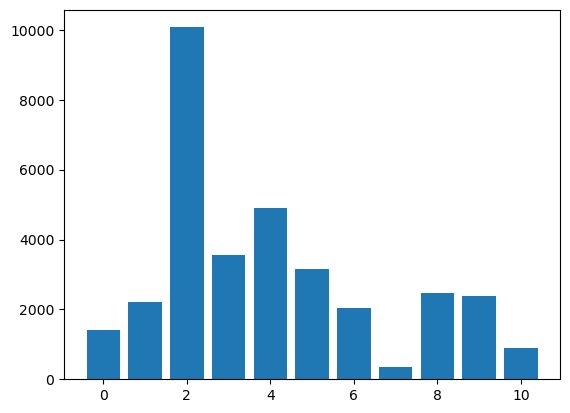

In [14]:
# Show current distribution of class data
distribution = np.zeros((11,1))
for i in range(11):
    distribution[i] = np.sum(train_labels_pp['label']==i)
plt.bar(range(11), distribution[:,0])
plt.show()

In [15]:
# Create new balanced train set
train_labels_pp_balanced = train_labels_pp.copy()

max_class_size = np.max(distribution)
for i in range(11):
    num_additional_data = max_class_size - distribution[i,0]
    
    if num_additional_data > 0:
        class_indices = np.where(train_labels_pp['label']==i)[0] # indices in the file of class i
        repeat_indices = np.random.randint(0, len(class_indices), num_additional_data.astype('int')) # get indices to repeat (randomly)
        new_data_indices = class_indices[repeat_indices] # now get the indices from the labels file
        
        train_labels_pp_balanced = pd.concat([train_labels_pp_balanced, train_labels_pp.iloc[new_data_indices]])
        
train_labels_pp_balanced

,image_name,label,P,speed,x_dir,y_dir,accel,ed,heating,turning,res_heat
0,Base_16462.png,4,0.188181,0.533370,1.013505,-1.001707,0.265683,-0.402862,-1,0,-0.246350
1,Base_20556.png,2,0.188181,-1.483871,-1.400466,-0.001226,-0.004820,1.192955,-1,0,2.264175
2,Base_4814.png,5,0.190648,0.546651,1.425913,-0.071883,-0.004820,-0.408649,-1,0,-0.075215
3,MPA_1853.png,2,0.112406,0.540621,1.427491,-0.024215,-0.004820,-0.430170,-1,0,-1.251619
4,MPA_6467.png,5,-0.135712,0.037674,-1.400466,-0.001226,-0.764178,-0.244449,-1,0,-0.345723
...,...,...,...,...,...,...,...,...,...,...,...
32059,MPA_14636.png,10,-4.207459,-0.168414,-1.400466,-0.001226,0.760277,-1.587748,1,0,-0.210994
13407,Base_35.png,10,-4.079523,1.214502,0.013606,-1.416120,-0.004820,-1.890032,-1,0,-1.772429
11532,Base_905.png,10,-4.078113,1.214502,-1.400466,-0.001226,-0.004820,-1.889640,1,0,-1.666125
22460,Base_169.png,10,-4.078113,-0.337062,1.427677,-0.001226,0.186455,-1.484037,0,0,-1.762192


In [16]:
# sort by label
train_labels_pp_balanced = train_labels_pp_balanced.sort_values(by=['label'])
train_labels_pp_balanced

,image_name,label,P,speed,x_dir,y_dir,accel,ed,heating,turning,res_heat
24362,MPA_5268.png,0,-3.853256,-2.727589,-1.061617,-0.920180,1.640584,0.476314,-1,1,0.102963
15253,Base_1341.png,0,0.189238,0.269406,-1.074998,0.901817,-5.421630,-0.265115,0,1,-1.608548
15220,Base_6258.png,0,0.190648,-0.680586,-0.334729,1.370068,-6.271058,0.373764,1,1,-0.326262
2290,MPA_3572.png,0,-1.079900,-2.094915,-0.659893,1.242879,0.186455,1.360501,1,0,-0.722043
8359,Base_1981.png,0,0.190648,0.269406,-1.074998,0.901817,-5.564948,-0.264650,1,1,-1.394639
...,...,...,...,...,...,...,...,...,...,...,...
3910,Base_591.png,10,-4.078113,1.214502,1.427677,-0.001226,-0.004820,-1.889640,0,0,-1.752105
13708,Base_452.png,10,-4.079523,1.214502,0.013606,1.413668,-0.004820,-1.890032,1,0,-1.713475
16510,Base_890.png,10,-4.078113,1.214502,-1.400466,-0.001226,-0.004820,-1.889640,1,0,-1.684841
13576,Base_503.png,10,-4.080580,1.214502,-1.400466,-0.001226,-0.004820,-1.890327,-1,0,-1.726033


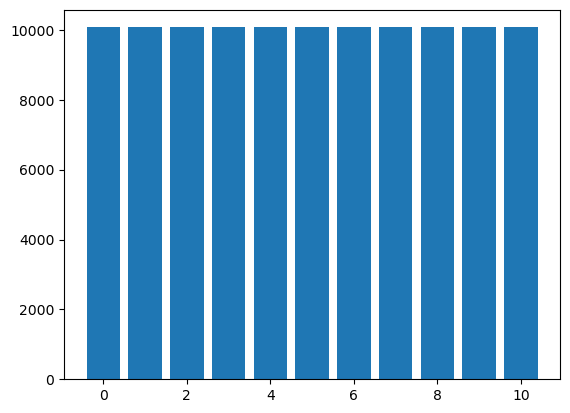

In [17]:
# Now have even distribution of data
new_distribution = np.zeros((11,1))
for i in range(11):
    new_distribution[i] = np.sum(train_labels_pp_balanced['label']==i)
plt.bar(range(11), new_distribution[:,0])
plt.show()

In [18]:
# Save the file
train_labels_pp_balanced.to_csv('neural_network_data/train_labels_pp_balanced_RTC11.csv',header=True, index=False)

### Add X/Y Coordinates to Process Parameters

In [49]:
# Load data
train_labels_pp = pd.read_csv('neural_network_data/train_labels_pp_RTC8.csv')
train_labels_pp

,image_name,label,P,speed,x_dir,y_dir,accel,ed,heating,turning,res_heat
0,Base_6581.png,3,0.190648,0.539909,0.013606,-1.416120,0.186455,-0.405323,0,0,-1.083283
1,MPA_17298.png,9,0.463437,0.539909,0.013606,-1.416120,-0.004820,-0.319908,1,0,0.466535
2,MPA_2364.png,0,0.146593,0.532420,-1.225426,0.680638,0.186455,-0.415432,1,0,-1.188800
3,MPA_17134.png,9,0.752439,0.435174,0.428197,-1.353942,-5.995704,-0.173174,1,1,0.128321
4,MPA_6154.png,6,0.097604,-0.343808,0.013606,-1.416120,0.454239,0.081852,1,0,-1.217461
...,...,...,...,...,...,...,...,...,...,...,...
33439,MPA_20028.png,0,2.249959,-1.483871,1.427677,-0.001226,-0.004820,2.225882,1,0,0.570584
33440,MPA_10337.png,0,0.153290,0.539909,-1.400466,-0.001226,-0.004820,-0.417020,1,0,0.181372
33441,Base_19608.png,0,0.189238,-1.487244,-1.400466,-0.001226,-0.023947,1.197753,-1,0,0.854443
33442,MPA_17985.png,0,1.009720,0.541680,-1.400001,0.035019,0.014308,-0.149816,-1,0,1.433560


In [187]:
train_labels_pp = train_labels_pp.sort_values(by=['image_name'])
train_labels_pp

,image_name,label,P,speed,x_dir,y_dir,accel,ed,heating,turning,res_heat
481848,layer100_100.png,11,-2.160818,1.081720,1.263737,-0.646039,0.020722,-1.134447,0,0,3.388374
632161,layer100_1000.png,5,0.412525,0.600790,0.913734,-1.089189,0.020722,-0.366317,0,0,2.657863
77894,layer100_1002.png,5,0.412525,0.600790,0.913734,-1.089189,0.022852,-0.366317,0,0,2.602031
769412,layer100_1003.png,5,0.412525,0.600790,0.913734,-1.089189,0.020722,-0.366317,0,0,2.574887
672989,layer100_1004.png,5,0.412525,0.600607,0.913778,-1.089152,0.018591,-0.366250,0,0,2.548210
...,...,...,...,...,...,...,...,...,...,...,...
365182,layer9_993.png,20,0.969956,-0.117673,1.004423,-1.005501,1.180677,0.143339,1,0,-0.204088
578971,layer9_994.png,16,1.465986,0.597053,1.004423,-1.005501,0.023735,-0.083294,0,0,-0.184545
481879,layer9_995.png,4,1.414569,0.511854,1.004423,-1.005501,-0.373964,-0.058721,-1,0,-0.164189
443043,layer9_997.png,19,0.972744,-0.123502,0.007509,-1.421354,0.847325,0.147868,1,0,-0.135948


In [188]:
# need to load x-y coordinates for all of these
last_layer = 0
image_names = np.array(train_labels_pp['image_name'])

X_coord = np.zeros(len(train_labels_pp))
Y_coord = np.zeros(len(train_labels_pp))

for ii in tqdm(range(len(train_labels_pp))):
    
    current_image_name = image_names[ii]
    current_layer = int(current_image_name[5:current_image_name.find('_')])
    image_num = int(current_image_name[current_image_name.find('_')+1:current_image_name.find('.png')])
    
    # Load csv file if layer is different
    if current_layer != last_layer:
        last_layer = current_layer
    
        if current_layer < 10:
            layer_text = 'layer000' + str(current_layer)
        elif current_layer < 100:
            layer_text = 'layer00' + str(current_layer)
        else:
            layer_text = 'layer0' + str(current_layer)
              
        data = pd.read_csv(DATA_DIR + 'T500_3D_Scan_Strategies_fused_' + layer_text + '.csv', header=None, 
                       names=['X', 'Y', 'P', 'T', 'deprecated'])
        
        # Collect the important info
        X = np.array(data['X'])
        Y = np.array(data['Y'])
        T = np.array(data['T'])
        indx = np.where(T!=0)
        X = X[indx]
        Y = Y[indx]

    X_coord[ii] = X[image_num-1]
    Y_coord[ii] = Y[image_num-1]
    

  0%|                                                                                                                          | 0/824765 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../../../In-situ Meas Data/Build Command Data/XYPT Commands/T500_3D_Scan_Strategies_fused_layer0100.csv'

In [52]:
train_labels_pp['X'] = X_coord
train_labels_pp['Y'] = Y_coord

In [54]:
train_labels_pp = train_labels_pp.sort_values(by=['label'])
train_labels_pp

,image_name,label,P,speed,x_dir,y_dir,accel,ed,heating,turning,res_heat,X,Y
102058,layer207_127.png,0,-2.160818,0.890077,-1.402037,0.027996,0.301970,-0.027271,0,0,0.106027,-34.330995,-25.489597
746778,layer119_2033.png,0,1.470079,0.603216,-1.388619,-0.199155,0.022852,-0.027271,0,0,-0.630986,35.982172,4.375500
778372,layer119_2035.png,0,1.470079,0.603183,-1.388631,-0.199068,0.017709,-0.027271,0,0,-0.630350,35.189604,4.264119
352553,layer119_2037.png,0,1.470079,0.602979,-1.388618,-0.199168,0.017709,-0.027271,0,0,-0.629401,34.397036,4.152739
459559,layer119_2039.png,0,1.470079,0.602979,-1.388618,-0.199168,0.017709,-0.027271,0,0,-0.628099,33.604468,4.041359
...,...,...,...,...,...,...,...,...,...,...,...,...,...
776437,layer224_2886.png,23,-0.321136,-0.750761,-0.520629,-1.317970,-0.850019,-0.027271,-1,0,-0.481341,7.997239,-4.684159
9466,layer224_2887.png,23,-1.523993,-2.917316,-0.521592,-1.317577,-0.401790,-0.027271,-1,0,-0.478180,7.947261,-4.807856
154352,layer224_2888.png,23,-1.689761,-3.203035,0.545128,1.310985,0.097091,-0.027271,1,0,-0.476689,8.032457,-4.861359
273559,layer224_2879.png,23,0.411649,0.599569,-0.520638,-1.317966,0.018591,-0.027271,0,0,-0.534954,9.026855,-2.135821


In [55]:
# Save as excel file
train_labels_pp.to_excel('neural_network_data/train_labels_pp_x_y.xlsx',header=True, index=False)

### Visualize Process Parameters 

In [4]:
train_labels_pp = pd.read_excel('neural_network_data/train_labels_pp_x_y.xlsx')
train_labels_pp

,image_name,label,P,speed,x_dir,y_dir,accel,ed,heating,turning,res_heat,X,Y
0,layer207_127.png,0,-2.160818,0.890077,-1.402037,0.027996,0.301970,-0.027271,0,0,0.106027,-34.330995,-25.489597
1,layer119_2033.png,0,1.470079,0.603216,-1.388619,-0.199155,0.022852,-0.027271,0,0,-0.630986,35.982172,4.375500
2,layer119_2035.png,0,1.470079,0.603183,-1.388631,-0.199068,0.017709,-0.027271,0,0,-0.630350,35.189604,4.264119
3,layer119_2037.png,0,1.470079,0.602979,-1.388618,-0.199168,0.017709,-0.027271,0,0,-0.629401,34.397036,4.152739
4,layer119_2039.png,0,1.470079,0.602979,-1.388618,-0.199168,0.017709,-0.027271,0,0,-0.628099,33.604468,4.041359
...,...,...,...,...,...,...,...,...,...,...,...,...,...
824760,layer224_2886.png,23,-0.321136,-0.750761,-0.520629,-1.317970,-0.850019,-0.027271,-1,0,-0.481341,7.997239,-4.684159
824761,layer224_2887.png,23,-1.523993,-2.917316,-0.521592,-1.317577,-0.401790,-0.027271,-1,0,-0.478180,7.947261,-4.807856
824762,layer224_2888.png,23,-1.689761,-3.203035,0.545128,1.310985,0.097091,-0.027271,1,0,-0.476689,8.032457,-4.861359
824763,layer224_2879.png,23,0.411649,0.599569,-0.520638,-1.317966,0.018591,-0.027271,0,0,-0.534954,9.026855,-2.135821


In [54]:
X = np.array(train_labels_pp['X'])
Y = np.array(train_labels_pp['Y'])
P = np.array(train_labels_pp['P'])
ed = np.array(train_labels_pp['ed'])
labels = np.array(train_labels_pp['label'])
res_heat = np.array(train_labels_pp['res_heat'])

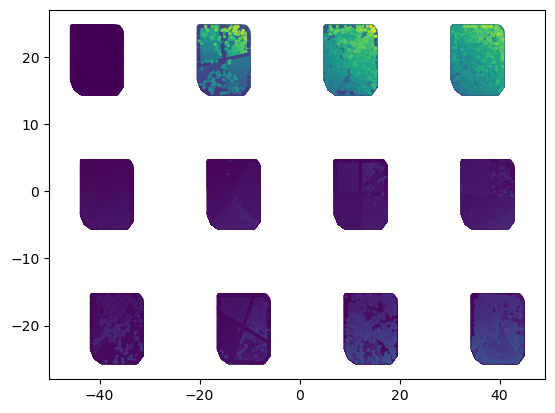

In [55]:
plt.scatter(X,Y,c=res_heat, s=2)
plt.show()

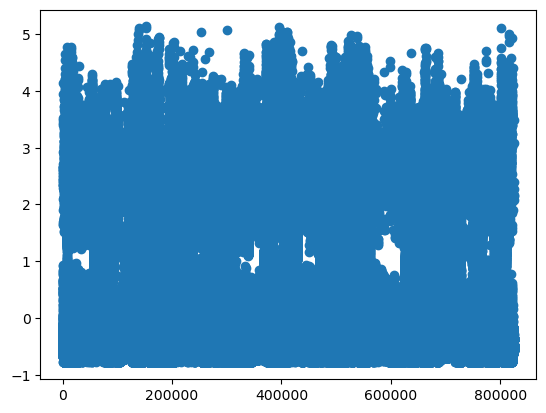

In [56]:
plt.scatter(range(len(ed)), res_heat)
plt.show()

In [15]:
np.min(ed)

-0.0272710345272976

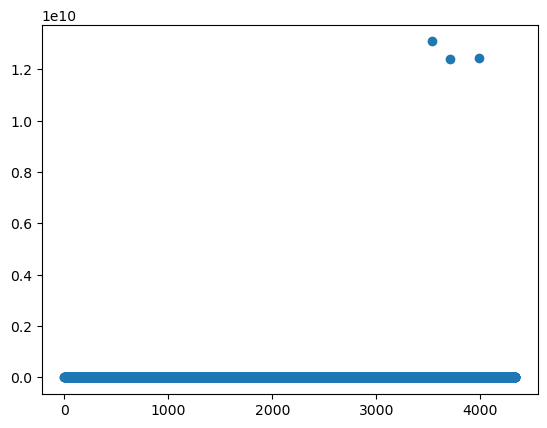

In [87]:
layer_num = 'layer0029'
pp_data = pd.read_excel('process_parameters/by_layer/' + layer_num + '.xlsx', header=None)
P = np.array(pp_data[0])
V = np.array(pp_data[1])
ed = np.array(pp_data[5])
res_heat = np.array(pp_data[8])
# outlier_indx = np.where(ed>1)
# ed[outlier_indx] = 0.6
plt.scatter(range(len(ed)), ed)
plt.show()

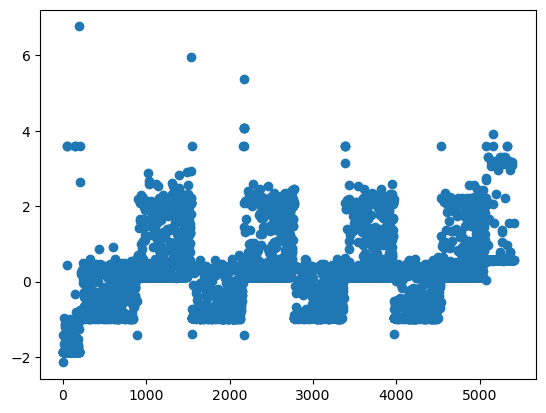

In [52]:
normalize_ed = (ed - np.mean(ed)) / np.std(ed)
plt.scatter(range(len(ed)), normalize_ed)
plt.show()

In [28]:
pp_data

,0,1,2,3,4,5,6,7,8
0,38.503188,424.708753,-0.736152,-0.676817,1.101718e+07,0.090658,1,1,3.251790e+08
1,85.861073,520.596391,-0.479834,0.877359,7.585842e+05,0.164928,1,0,3.260126e+08
2,105.067759,901.746978,-0.479846,0.877353,4.589390e+04,0.116516,1,0,3.307790e+08
3,104.921043,897.987991,-0.479851,0.877350,-1.420607e+05,0.116840,-1,0,3.366090e+08
4,84.842039,493.453407,-0.479782,0.877388,-5.818075e+05,0.171935,-1,0,3.413556e+08
...,...,...,...,...,...,...,...,...,...
2873,165.757861,500.050000,1.000000,0.000000,-2.500000e+03,0.331483,0,0,2.125760e+08
2874,165.757861,500.100000,1.000000,0.000000,2.500000e+03,0.331449,0,0,2.141308e+08
2875,165.757861,500.100000,1.000000,0.000000,2.500000e+03,0.331449,0,0,2.156974e+08
2876,165.757861,500.050000,1.000000,0.000000,2.500000e+03,0.331483,0,0,2.172768e+08


In [92]:
outlier_indx = np.where(ed>100)

In [93]:
P[outlier_indx]

array([ 87.817062, 117.025635,  58.826637, 117.048965, 117.01584 ,
       117.048916, 117.049014, 117.007644, 117.048843, 117.029177,
       117.01523 , 117.059772, 117.008278, 117.003996, 117.084745,
       117.040299, 117.048967, 130.814349, 117.076749, 123.884233,
       117.029135, 117.048997, 117.01584 , 124.342539])

In [94]:
V[outlier_indx]

array([0.6670832 , 0.30413813, 0.57008771, 0.57008771, 0.18027756,
       0.57008771, 0.57008771, 0.07071068, 0.57008771, 0.36055513,
       0.15811388, 0.65764732, 0.1       , 0.05      , 0.9617692 ,
       0.45276926, 0.57008771, 0.        , 0.86023253, 0.        ,
       0.32015621, 0.57008771, 0.18027756, 0.        ])

In [100]:
new_ed = np.array(pp_data[5])
new_ed[np.where(new_ed>1)] = 1
pp_data[5] = new_ed
np.max(new_ed)

1.0

In [102]:
pp_data

,0,1,2,3,4,5,6,7,8
0,38.472188,423.388194,-0.779427,-0.626494,1.100467e+07,0.090867,1,1,5.916933e+07
1,83.591537,473.344792,0.970329,-0.241790,3.710795e+05,0.176598,1,0,5.968475e+07
2,103.438622,871.357986,0.970324,-0.241806,4.383848e+05,0.118710,1,0,6.086251e+07
3,104.977904,899.540645,0.970329,-0.241790,0.000000e+00,0.116702,0,0,6.251141e+07
4,104.977904,899.540645,0.970329,-0.241790,0.000000e+00,0.116702,0,0,6.423516e+07
...,...,...,...,...,...,...,...,...,...
4331,165.729532,499.750000,0.000000,-1.000000,-2.500000e+03,0.331625,0,0,1.262676e+07
4332,165.729532,499.750000,0.000000,-1.000000,-2.500000e+03,0.331625,0,0,1.308499e+07
4333,165.729532,499.800000,0.000000,-1.000000,2.500000e+03,0.331592,0,0,1.353792e+07
4334,151.150227,345.250000,0.000000,-1.000000,-9.650000e+05,0.437799,-1,0,1.396020e+07


In [105]:
new_ed = np.array(pp_data[5])
np.min(new_ed)

0.09086740862990646